# Modelo de detección de enfermedades de tiroides

## Definición del *pipeline*

In [1]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class AgeOutlierImputer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to handle age outliers by imputing values over 150 
    with the median age of the dataset.
    """
    def __init__(self, threshold=150):
        self.threshold = threshold
        self.median_age = None
        
    def fit(self, X, y=None):
        # Calculate median age excluding outliers
        self.median_age = np.median(X[X <= self.threshold])
        return self
        
    def transform(self, X):
        X_copy = X.copy()
        mask = X_copy > self.threshold
        X_copy[mask] = self.median_age
        return X_copy

In [2]:
class TSHLogTransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to handle TSH's right-skewed distribution 
    using log transformation with handling of zeros.
    """
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X_copy = X.copy()
        # Add small constant before log transform to handle zeros
        return np.log1p(X_copy)

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer


standard_numeric = ['TT4', 'T4U', 'FTI', 'T3']

# Special handling for TSH (right-skewed distribution)
tsh_feature = ['TSH']


# Binary categorical features
binary_features = ['on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_meds',
                    'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment',
                    'query_hypothyroid', 'query_hyperthyroid', 'lithium',
                    'goitre', 'tumor', 'hypopituitary', 'psych']

# categorical categorical features
categorical_features = ['sex', 'referral_source']

# Create specialized pipelines
age_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('outlier_handler', AgeOutlierImputer(threshold=150)),
    ('scaler', StandardScaler())
])

standard_numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

tsh_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log_transform', TSHLogTransformer()),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])


# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('age', age_pipeline, ['age']),
        ('standard_numeric', standard_numeric_pipeline, standard_numeric),
        ('tsh', tsh_pipeline, tsh_feature),
        ('binary', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False), 
            binary_features),
        ('categorical', categorical_pipeline, categorical_features),
    ],
    remainder='drop' # NOTA: el comentario previo aquí indicaba que esto eliminaba TBG, sin embargo, se está eliminando explícitamente antes de pasar el pipeline. No era un problema, simplemente redundante (más robusto así), por lo que se eliminó el comentario para no confundir.
)


El argumento `drop='if_binary'` de OneHotEncoder permite eliminar una de las columnas de salida cuando la variable categórica es binaria (crear una columna para f y otra para t es redundante).

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

pipeline_random_forest = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42))
])


pipeline_logistic_regression = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

## *Pipeline* de entrenamiento

### Carga y preparación de datos

In [5]:
import pandas as pd
file_path = "./data/thyroidDF.csv"
df = pd.read_csv(file_path)

# Simplify the target variable
class_mapping = {
    '-': 'negative',
    'K': 'positive', 'B': 'positive', 'H|K': 'positive',
    'KJ': 'positive', 'GI': 'positive',
    'G': 'positive', 'I': 'positive', 'F': 'positive', 'C|I': 'positive',
    'E': 'negative', 'LJ': 'negative', 'D|R': 'negative',
}

df['target'] = df['target'].map(class_mapping)

df = df.dropna(subset=['target'])

In [6]:
from sklearn.model_selection import train_test_split
measured_cols = [col for col in df.columns if col.endswith('_measured')]

columns_to_drop = [
    'patient_id',
    *measured_cols,  # Unpack the list of measured columns
    'TBG', # excessive missing values (96,6%)
]

X = df.drop(columns_to_drop + ['target'], axis=1)
y = df['target']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

### Evaluación y elección de modelos mediante *cross-validation*

Comparamos dos modelos con cross-validation, uno con los datos originales y otro con los datos escalados.

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_random_forest = cross_val_score(pipeline_random_forest, X_train, y_train, cv=stratified_cv, scoring='accuracy')
scores_svm = cross_val_score(pipeline_svm, X_train, y_train, cv=stratified_cv, scoring='accuracy')
scores_logistic_regression = cross_val_score(pipeline_logistic_regression, X_train, y_train, cv=stratified_cv, scoring='accuracy')

print(f'Random Forest: {scores_random_forest.mean()}')
print(f'SVM: {scores_svm.mean()}')
print(f'Logistic Regression: {scores_logistic_regression.mean()}')

Random Forest: 0.9683308583756162
SVM: 0.9386417988479565
Logistic Regression: 0.8845917363074557


Hemos evaluado sobre sobre la *accuracy* (scoring='accuracy'). Sin embargo, tenemos unas clases un poco desbalanceadas, y además es más importante detectar los casos positivos (enfermos) que los negativos (sanos). Vamos por tanto a priorizar la sensibilidad (recall) en la evaluación de los modelos. Crearemos un evaluador personalizado que devuelva la *recall* media de las dos clases positivas (hypothyroid y hyperthyroid).

In [10]:
from sklearn.metrics import make_scorer, recall_score
import numpy as np

def custom_recall(y_true, y_pred):
    # Get original class names from the LabelEncoder
    all_classes = le.classes_
    # Calculate recall for each class using original labels
    recalls = recall_score(le.inverse_transform(y_true), 
                          le.inverse_transform(y_pred), 
                          labels=all_classes, 
                          average=None, 
                          zero_division=0)
    # Get indices for disease classes
    disease_indices = [np.where(all_classes == cls)[0][0] 
                      for cls in ['positive']]
    return np.mean(recalls[disease_indices])

disease_recall_scorer = make_scorer(custom_recall)

scores_random_forest = cross_val_score(pipeline_random_forest, X_train, y_train, 
                                      cv=5, scoring=disease_recall_scorer)
scores_svm = cross_val_score(pipeline_svm, X_train, y_train, 
                            cv=5, scoring=disease_recall_scorer)
scores_logistic_regression = cross_val_score(pipeline_logistic_regression, X_train, y_train, 
                            cv=5, scoring=disease_recall_scorer)

print(f'Random Forest Disease Recall: {scores_random_forest.mean():.3f}')
print(f'SVM Disease Recall: {scores_svm.mean():.3f}')
print(f'Logistic Regression Disease Recall: {scores_logistic_regression.mean():.3f}')

Random Forest Disease Recall: 0.898
SVM Disease Recall: 0.785
Logistic Regression Disease Recall: 0.439


Observamos que el modelo Random Forest sigue siendo el mejor de los dos que hemos probado.

Mario: Para el examen cambio la evaluación final para hacerla con el algoritmo de Regresión Logística.

### Evaluación final en el conjunto de test

In [11]:
#y_pred = pipeline_random_forest.fit(X_train, y_train).predict(X_test)
y_pred = pipeline_logistic_regression.fit(X_train, y_train).predict(X_test)

c:\Users\a24mariorb\AppData\Local\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


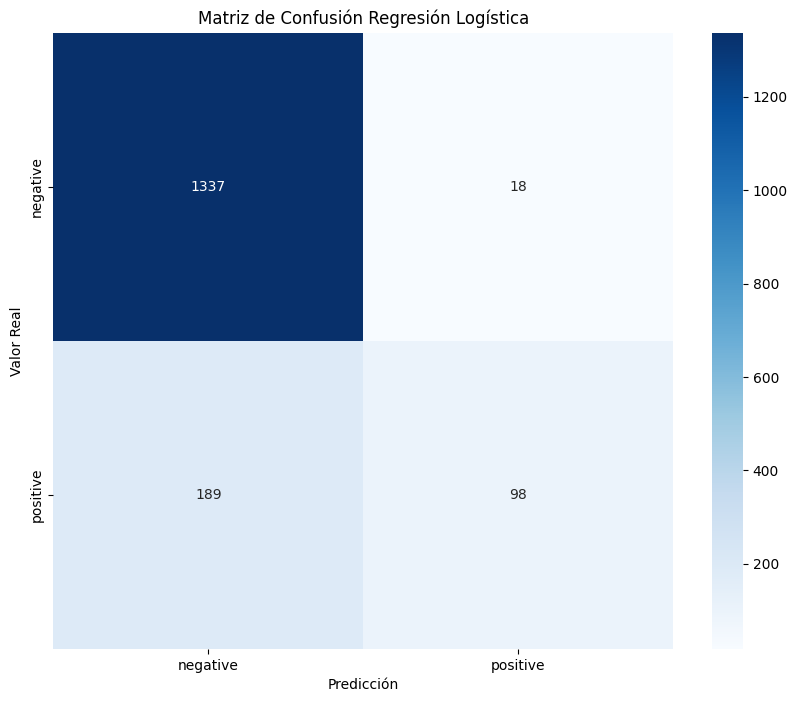

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Matriz de Confusión Regresión Logística')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1355
           1       0.84      0.34      0.49       287

    accuracy                           0.87      1642
   macro avg       0.86      0.66      0.71      1642
weighted avg       0.87      0.87      0.85      1642

